# Changepoint Detection

Think Bayes, Second Edition

Copyright 2020 Allen B. Downey

License: [Attribution-NonCommercial-ShareAlike 4.0 International (CC BY-NC-SA 4.0)](https://creativecommons.org/licenses/by-nc-sa/4.0/)

In [1]:
# If we're running on Colab, install empiricaldist
# https://pypi.org/project/empiricaldist/

import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    !pip install empiricaldist

In [488]:
# Get utils.py

from os.path import basename, exists

def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)
    
download('https://github.com/AllenDowney/ThinkBayes2/raw/master/soln/utils.py')

In [489]:


import numpy as np
import pandas as pd





In [490]:
n = 60
t1 = 30
t2 = n-t1
lam1 = 4
lam2 = 2

In [491]:
from scipy.stats import poisson

before = poisson(lam1).rvs(t1)
before

array([3, 5, 6, 4, 1, 5, 3, 6, 4, 2, 4, 1, 7, 1, 6, 6, 3, 3, 3, 4, 2, 5,
       5, 0, 5, 9, 4, 4, 4, 2])

In [492]:
after = poisson(lam2).rvs(t2)
after

array([6, 1, 0, 0, 1, 1, 0, 0, 2, 3, 0, 0, 1, 3, 1, 1, 3, 2, 1, 1, 1, 2,
       2, 2, 2, 2, 4, 4, 3, 1])

In [493]:
data = np.concatenate([before, after])

In [494]:
n = len(data)
lam = 2
lams = np.linspace(0, 10, 51)

In [495]:
D, L = np.meshgrid(data, lams)
like1 = poisson.pmf(D, L).prod(axis=1)
like1 /= like1.sum()

In [496]:
like2 = poisson.pmf(np.sum(data), n*lams)
like2 /= like2.sum()

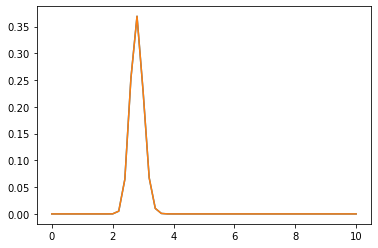

In [497]:
import matplotlib.pyplot as plt
plt.plot(lams, like1)
plt.plot(lams, like2)

In [498]:
np.sum(lams * like1), np.sum(lams * like2)

(2.800000000617144, 2.8000000006171466)

In [499]:
poisson.pmf(before, 4)

array([0.19536681, 0.15629345, 0.10419563, 0.19536681, 0.07326256,
       0.15629345, 0.19536681, 0.10419563, 0.19536681, 0.14652511,
       0.19536681, 0.07326256, 0.05954036, 0.07326256, 0.10419563,
       0.10419563, 0.19536681, 0.19536681, 0.19536681, 0.19536681,
       0.14652511, 0.15629345, 0.15629345, 0.01831564, 0.15629345,
       0.01323119, 0.19536681, 0.19536681, 0.19536681, 0.14652511])

In [500]:
poisson.pmf(after, 2)

array([0.0120298 , 0.27067057, 0.13533528, 0.13533528, 0.27067057,
       0.27067057, 0.13533528, 0.13533528, 0.27067057, 0.18044704,
       0.13533528, 0.13533528, 0.27067057, 0.18044704, 0.27067057,
       0.27067057, 0.18044704, 0.27067057, 0.27067057, 0.27067057,
       0.27067057, 0.27067057, 0.27067057, 0.27067057, 0.27067057,
       0.27067057, 0.09022352, 0.09022352, 0.18044704, 0.27067057])

In [636]:
t = 7

In [637]:
def likelihood1(data, t, lam1, lam2):
    before = data[:t]
    after = data[t:]
    like1 = poisson.pmf(before, lam1).prod()
    like2 = poisson.pmf(after, lam2).prod()
    return like1

In [638]:
like1 = likelihood1(data, t, 4, 2)
like1

1.3904825453454708e-06

In [639]:
from scipy.special import binom

def combos(data):
    data = np.asarray(data)
    n = data.sum()
    k = len(data)
    print(n, k)
    ns = n - np.cumsum(data) + data
    print(ns)
    print(data)
    cs = binom(ns, data)
    print(cs)
    return cs.prod() / k**n

In [640]:
combos(data[:t])

27 7
[27 24 19 13  9  8  3]
[3 5 6 4 1 5 3]
[2.9250e+03 4.2504e+04 2.7132e+04 7.1500e+02 9.0000e+00 5.6000e+01
 1.0000e+00]


0.24022923713083533

In [633]:
from scipy.special import binom

def likelihood2(data, t, lam1, lam2):
    before = data[:t].sum()
    like1 = poisson.pmf(before, lam1*t) * combos(data[:t])

    after = data[t:].sum()
    t2 = len(data) - t    
    n, k = after, t2
    like2 = poisson.pmf(after, lam2*t2)
    return like1

In [634]:
like2 = likelihood2(data, t, 4, 2)
like2

24 6
[24 21 16 10  6  5]
[3 5 6 4 1 5]
[2.0240e+03 2.0349e+04 8.0080e+03 2.1000e+02 6.0000e+00 1.0000e+00]


7.117291371491338e-06

In [635]:
like2 / like1

1.000000000000008

In [580]:
from empiricaldist import Pmf

ts = range(1, len(data))
prior_t = Pmf(1, ts)

In [84]:
lams1 = np.linspace(0, 10, 51)
prior_lam1 = Pmf(1, lams1)

In [85]:
lams2 = np.linspace(0, 10, 41)
prior_lam2 = Pmf(1, lams2)

In [86]:
from utils import make_joint

def make_joint3(pmf1, pmf2, pmf3):
    """Make a joint distribution with three parameters."""
    joint2 = make_joint(pmf2, pmf1).stack()
    joint3 = make_joint(pmf3, joint2).stack()
    return Pmf(joint3)

In [87]:
joint_prior = make_joint3(prior_t, prior_lam1, prior_lam2)
joint_prior.head()

1  0.0  0.00    1
        0.25    1
        0.50    1
Name: , dtype: int64

## Likelihood

In [88]:
ts

range(1, 60)

In [89]:
lams1

array([ 0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2,  1.4,  1.6,  1.8,  2. ,
        2.2,  2.4,  2.6,  2.8,  3. ,  3.2,  3.4,  3.6,  3.8,  4. ,  4.2,
        4.4,  4.6,  4.8,  5. ,  5.2,  5.4,  5.6,  5.8,  6. ,  6.2,  6.4,
        6.6,  6.8,  7. ,  7.2,  7.4,  7.6,  7.8,  8. ,  8.2,  8.4,  8.6,
        8.8,  9. ,  9.2,  9.4,  9.6,  9.8, 10. ])

In [90]:
T, L = np.meshgrid(ts, lams1)
M = T * L
M.shape

(51, 59)

In [91]:
C = np.cumsum(data)[:-1]
C.shape

(59,)

In [92]:
from scipy.special import binom

like1 = poisson.pmf(C, M) / binom(C+T-1, T-1)
like1.shape

(51, 59)

In [93]:
ts2 = len(data) - np.array(ts)
ts2

array([59, 58, 57, 56, 55, 54, 53, 52, 51, 50, 49, 48, 47, 46, 45, 44, 43,
       42, 41, 40, 39, 38, 37, 36, 35, 34, 33, 32, 31, 30, 29, 28, 27, 26,
       25, 24, 23, 22, 21, 20, 19, 18, 17, 16, 15, 14, 13, 12, 11, 10,  9,
        8,  7,  6,  5,  4,  3,  2,  1])

In [94]:
T2, L2 = np.meshgrid(ts2, lams2)
M2 = T2 * L2
M2.shape

(41, 59)

In [31]:
C2 = sum(data) - C
C2.shape

(59,)

In [96]:
like2 = poisson.pmf(C2, M2) / binom(C2+T2-1, T2-1)
like2.shape

(41, 59)

In [97]:
like = like1.T[:, :, None] * like2.T[:, None, :]
like.shape

(59, 51, 41)

In [98]:
like.flatten().shape

(123369,)

In [99]:
from utils import normalize

joint_posterior = joint_prior * like.reshape(-1)
normalize(joint_posterior)

2.820090395696955e-54

In [100]:
from utils import pmf_marginal

posterior_t = pmf_marginal(joint_posterior, 0)
posterior_t.head(3)

,probs
1,0.001398
2,0.001117
3,0.001281


<AxesSubplot:>

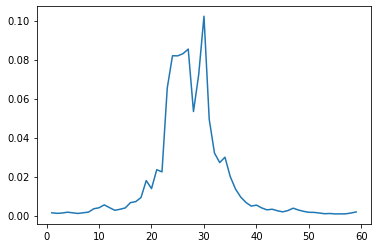

In [101]:
posterior_t.plot()

<AxesSubplot:>

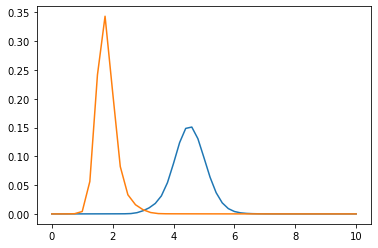

In [102]:
posterior_lam1 = pmf_marginal(joint_posterior, 1)
posterior_lam2 = pmf_marginal(joint_posterior, 2)

posterior_lam1.plot()
posterior_lam2.plot()


## Doing it the long way

In [103]:
likelihood = joint_prior.copy().unstack().unstack()
likelihood.head()

0.0                                                ... 10.0                 \
  0.0  0.2  0.4  0.6  0.8  1.0  1.2  1.4  1.6  1.8   ... 8.2  8.4  8.6  8.8    
1    1    1    1    1    1    1    1    1    1    1  ...    1    1    1    1   
2    1    1    1    1    1    1    1    1    1    1  ...    1    1    1    1   
3    1    1    1    1    1    1    1    1    1    1  ...    1    1    1    1   
4    1    1    1    1    1    1    1    1    1    1  ...    1    1    1    1   
5    1    1    1    1    1    1    1    1    1    1  ...    1    1    1    1   

                                 
  9.0  9.2  9.4  9.6  9.8  10.0  
1    1    1    1    1    1    1  
2    1    1    1    1    1    1  
3    1    1    1    1    1    1  
4    1    1    1    1    1    1  
5    1    1    1    1    1    1  

[5 rows x 2091 columns]

In [104]:
t = 30
row = likelihood.loc[t].unstack()
row.head()

,0.0,0.2,0.4,0.6,0.8,1.0,1.2,1.4,1.6,1.8,...,8.2,8.4,8.6,8.8,9.0,9.2,9.4,9.6,9.8,10.0
0.00,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
0.25,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
0.50,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
0.75,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
1.00,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


In [105]:
lams = row.columns
lams.shape

(51,)

In [106]:
lam_mesh, data_mesh = np.meshgrid(lams, data[:t])
probs = poisson.pmf(data_mesh, lam_mesh)
probs.shape

(30, 51)

In [107]:
likelihood1 = probs.prod(axis=0)
likelihood1.shape

(51,)

In [108]:
lams = row.index
lams.shape

(41,)

In [109]:
lam_mesh, data_mesh = np.meshgrid(lams, data[t:])
probs = poisson.pmf(data_mesh, lam_mesh)
probs.shape

(30, 41)

In [110]:
likelihood2 = probs.prod(axis=0)
likelihood2.shape

(41,)

In [111]:
likelihood_row = np.multiply.outer(likelihood2, likelihood1)
likelihood_row.shape

(41, 51)

In [112]:
likelihood.loc[t] = likelihood_row.flatten()

In [113]:
likelihood.loc[t]

0.0   0.0      0.000000e+00
      0.2      0.000000e+00
      0.4      0.000000e+00
      0.6      0.000000e+00
      0.8      0.000000e+00
                  ...      
10.0  9.2     3.826541e-140
      9.4     1.656773e-141
      9.6     6.754070e-143
      9.8     2.598919e-144
      10.0    9.461451e-146
Name: 30, Length: 2091, dtype: float64

In [114]:
likelihood = joint_prior.copy().unstack().unstack()
likelihood.head()

0.0                                                ... 10.0                 \
  0.0  0.2  0.4  0.6  0.8  1.0  1.2  1.4  1.6  1.8   ... 8.2  8.4  8.6  8.8    
1    1    1    1    1    1    1    1    1    1    1  ...    1    1    1    1   
2    1    1    1    1    1    1    1    1    1    1  ...    1    1    1    1   
3    1    1    1    1    1    1    1    1    1    1  ...    1    1    1    1   
4    1    1    1    1    1    1    1    1    1    1  ...    1    1    1    1   
5    1    1    1    1    1    1    1    1    1    1  ...    1    1    1    1   

                                 
  9.0  9.2  9.4  9.6  9.8  10.0  
1    1    1    1    1    1    1  
2    1    1    1    1    1    1  
3    1    1    1    1    1    1  
4    1    1    1    1    1    1  
5    1    1    1    1    1    1  

[5 rows x 2091 columns]

In [115]:
for t in likelihood.index:
    row = likelihood.loc[t].unstack()
    lams = row.columns
    lam_mesh, data_mesh = np.meshgrid(lams, data[:t])
    probs = poisson.pmf(data_mesh, lam_mesh)
    likelihood1 = probs.prod(axis=0)

    lams = row.index
    lam_mesh, data_mesh = np.meshgrid(lams, data[t:])
    probs = poisson.pmf(data_mesh, lam_mesh)
    likelihood2 = probs.prod(axis=0)

    likelihood_row = np.multiply.outer(likelihood2, likelihood1)
    likelihood.loc[t] = likelihood_row.flatten()

In [116]:
from utils import normalize

def update(prior, data):
    """
    
    prior: Pmf representing the joint prior
    data: sequence f counts
    
    returns: Pmf representing the joint posterior
    """
    likelihood = joint_prior.copy().unstack().unstack()

    for t in likelihood.index:
        row = likelihood.loc[t].unstack()
        lams = row.columns
        lam_mesh, data_mesh = np.meshgrid(lams, data[:t])
        probs = poisson.pmf(data_mesh, lam_mesh)
        likelihood1 = probs.prod(axis=0)

        lams = row.index
        lam_mesh, data_mesh = np.meshgrid(lams, data[t:])
        probs = poisson.pmf(data_mesh, lam_mesh)
        likelihood2 = probs.prod(axis=0)
        
        likelihood_row = np.multiply.outer(likelihood2, likelihood1)
        likelihood.loc[t] = likelihood_row.flatten()

    posterior = prior * likelihood.stack().stack()
    normalize(posterior)
    return posterior

In [117]:
posterior = update(joint_prior, data)

In [118]:
from utils import pmf_marginal

posterior_t = pmf_marginal(posterior, 0)
posterior_t.head(3)

,probs
1,5.378171e-10
2,3.792866e-10
3,4.223434e-10


<AxesSubplot:>

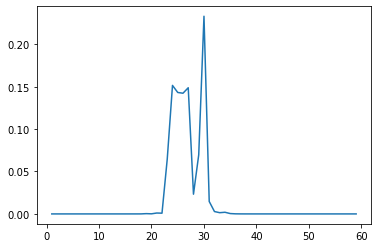

In [119]:
posterior_t.plot()

<AxesSubplot:>

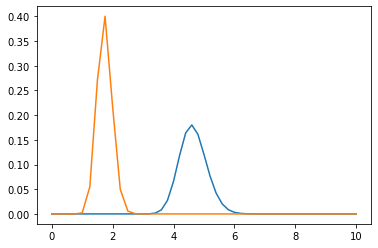

In [56]:
posterior_lam1 = pmf_marginal(posterior, 1)
posterior_lam2 = pmf_marginal(posterior, 2)

posterior_lam1.plot()
posterior_lam2.plot()

## Using emcee

In [57]:
try:
    import emcee
except:
    !pip install emcee

In [58]:
import emcee
print(emcee.__version__)

3.1.0


In [59]:
try:
    import corner
except ImportError:
    !pip install corner

In [60]:
try:
    import tdqm
except ImportError:
    !pip install tdqm

In [75]:
from scipy.stats import poisson
from scipy.stats import gamma

alpha, beta = 3, 1

def log_prior(theta):
    t, lam1, lam2 = theta
    return gamma.logpdf([lam1, lam2], alpha, beta).sum()

def log_likelihood(theta, data):
    t, lam1, lam2 = theta
    t = int(t)
    k1 = data[:t]
    k2 = data[t:]
    like1 = poisson.logpmf(k1, lam1).sum()
    like2 = poisson.logpmf(k2, lam2).sum()
    return like1 + like2

def log_posterior(theta, data):
    t, lam1, lam2 = theta
    if t < 1 or t >= len(data):
        return -np.inf
    if lam1 < 0 or lam2 < 0:
        return -np.inf
    return log_likelihood(theta, data)

In [76]:
ndim = 3  # number of parameters in the model
nwalkers = 50  # number of MCMC walkers
nburn = 500  # "burn-in" period to let chains stabilize
nsteps = 2500  # number of MCMC steps to take

In [77]:
np.random.seed(0)
com = 30, 3, 3
starting_guesses = com + np.random.random((nwalkers, ndim))

In [78]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=[data])
state = sampler.run_mcmc(starting_guesses, nsteps, progress=True)

100%|██████████| 2500/2500 [00:18<00:00, 132.76it/s]


In [79]:
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
flat_samples.shape

(8000, 3)

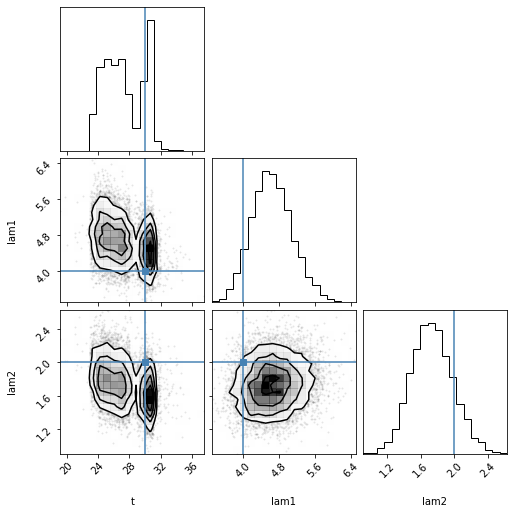

In [80]:
import corner

truths = [30, 4, 2]
labels = ['t', 'lam1', 'lam2']
fig = corner.corner(flat_samples, labels=labels, truths=truths);

In [67]:
stop

NameError: name 'stop' is not defined

Based on an example from Chapter 1 of [Bayesian Methods for Hackers](http://nbviewer.jupyter.org/github/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/blob/master/Chapter1_Introduction/Ch1_Introduction_PyMC2.ipynb)

and this example from [Computational Statistics in Python](http://people.duke.edu/~ccc14/sta-663-2016/16C_PyMC3.html#Changepoint-detection)

In [ ]:
import pymc3 as pm

In [ ]:
n = len(data)
t = range(n)
alpha = 1.0 / np.mean(data)

In [ ]:
import theano.tensor as T

with pm.Model() as model:
    tau = pm.DiscreteUniform('tau', lower=0, upper=n)
    lam1 = pm.Exponential('lam1', alpha)
    lam2 = pm.Exponential('lam2', alpha)
    lam = T.switch(t < tau, lam1, lam2)
    Y_obs = pm.Poisson('Y_obs', lam, observed=data)
    trace = pm.sample(10000, tune=2000)

In [ ]:
pm.traceplot(trace);

In [ ]:
tau_sample = trace['tau']
cdf_tau = Cdf(tau_sample)
thinkplot.Cdf(cdf_tau)

In [ ]:
lam1_sample = trace['lam1']
cdf_lam1 = Cdf(lam1_sample)
thinkplot.Cdf(cdf_lam1)

lam2_sample = trace['lam2']
cdf_lam2 = Cdf(lam2_sample)
thinkplot.Cdf(cdf_lam2)

In [ ]:
stop

In [ ]:
# !wget https://raw.githubusercontent.com/baltimore-sun-data/2018-shootings-analysis/master/BPD_Part_1_Victim_Based_Crime_Data.csv

In [ ]:

df = pd.read_csv('BPD_Part_1_Victim_Based_Crime_Data.csv', parse_dates=[0])
df.head()

In [ ]:
df.shape

In [ ]:
shootings = df[df.Description.isin(['HOMICIDE', 'SHOOTING']) & (df.Weapon == 'FIREARM')]
shootings.shape

In [ ]:
grouped = shootings.groupby('CrimeDate')

In [ ]:
counts = grouped['Total Incidents'].sum()
counts.head()

In [ ]:
index = pd.date_range(counts.index[0], counts.index[-1])

In [ ]:
counts = counts.reindex(index, fill_value=0)
counts.head()

In [ ]:
counts.plot()
thinkplot.decorate(xlabel='Date',
                   ylabel='Number of shootings')
